# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.3 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')
import torch 
import cv2
import random

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

import torchvision
from torchvision import transforms as T
from PIL import Image

import albumentations as A

In [3]:
file='/kaggle/working/Human-Segmentation-Dataset-master/train.csv'
data='/kaggle/'
device='cuda'

In [4]:
epoch=25
lr=0.003
image_size=320
batch_size=16

# ENCODER='time-efficientnet-b0'
ENCODER='resnet18'
WEIGHTS='imagenet'

In [5]:
df=pd.read_csv(file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [11]:
row=df.iloc[1]
img=row.images
img_mask=row.masks

img=cv2.imread(img)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img_mask=cv2.imread(img_mask,cv2.IMREAD_GRAYSCALE)/255.0

(183, 275, 3)


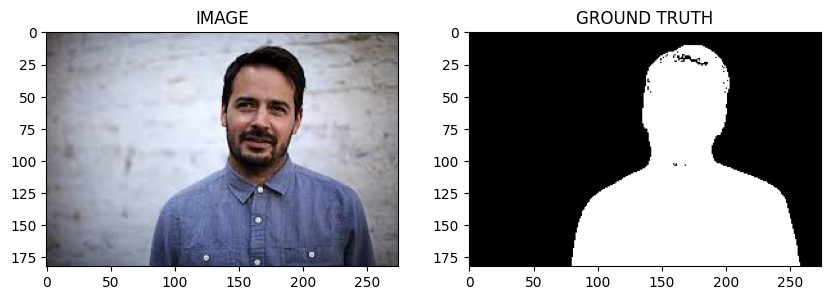

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

print(img.shape)
        
ax1.set_title('IMAGE')
ax1.imshow(img)

ax2.set_title('GROUND TRUTH')
ax2.imshow(img_mask,cmap = 'gray')

In [13]:
train_df,test_df=train_test_split(df,test_size=0.2, random_state=42)

In [14]:
def get_train_augs():
    return A.Compose([
      A.Resize(image_size, image_size), 
      A.HorizontalFlip(p = 0.5), 
      A.VerticalFlip(p = 0.5), 
      ], is_check_shapes=False)

def get_valid_augs():
    return A.Compose([
      A.Resize(image_size, image_size),
      ], is_check_shapes=False)

In [15]:
class SegmentationDataset(Dataset):
    
    def __init__(self,df,augmentation):
        self.df=df
        self.augmentation=augmentation
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row=self.df.iloc[idx]
        
        img=row.images
        img_mask=row.masks
        
        img=cv2.imread(img)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        img_mask=cv2.imread(img_mask,cv2.IMREAD_GRAYSCALE)
        print(img_mask)
        img_mask=np.expand_dims(img_mask,axis=-1)
        
        print(img_mask)
        
        if self.augmentation:
            data=self.augmentation(image=img,mask=img_mask,is_check_shapes=False)
            img=data['image']
            img_mask=data['mask']
            
            img=np.transpose(img,(2,0,1)).astype(np.float32)
            img_mask=np.transpose(img_mask,(2,0,1)).astype(np.float32)
        
            img=torch.Tensor(img)/255.0
            img_mask=torch.round(torch.Tensor(img_mask))/255.0 
            
        return img, img_mask

In [16]:
train=SegmentationDataset(train_df,get_train_augs())
valid=SegmentationDataset(test_df,get_valid_augs())

In [17]:
print("Train size:",len(train))
print("Validation size:",len(valid))

Train size: 232
Validation size: 58


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
[[[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 ...

 [[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]

 [[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]

 [[  0]
  [  0]
  [  0]
  ...
  [255]
  [255]
  [255]]]
torch.Size([320, 320, 3])
torch.Size([1, 320, 320])


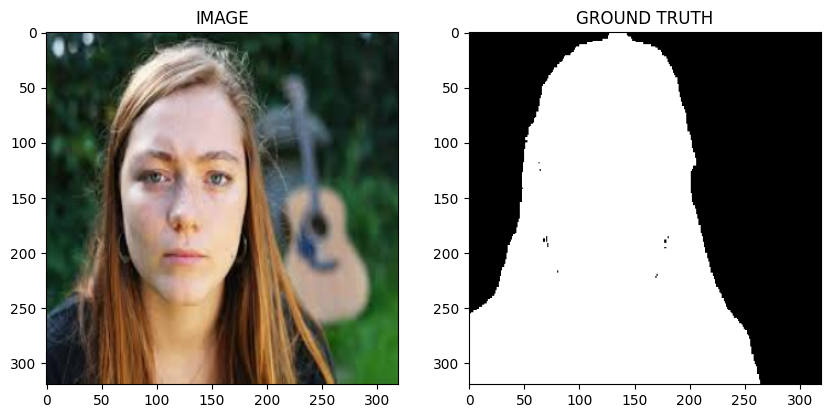

In [18]:
img,img_mask=train[0]
# print(img.permute(1,2,0).shape)
# print(img_mask.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(img.permute(1,2,0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(img_mask[0],cmap = 'gray')

In [ ]:
trainloader=DataLoader(train,batch_size=batch_size, shuffle=True)
validloader=DataLoader(valid,batch_size=batch_size)

In [ ]:
print("Total number of batches in train",len(trainloader))
print("Total number of batches in validation",len(validloader))

In [ ]:
for img,img_mask in trainloader:
    break
print("Batch Image Shape",img.shape)
print("Batch Mask Shape",img_mask.shape)

In [ ]:
class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel,self).__init__()
        
        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
        
    def forward(self,images,masks=None):
        logits=self.arc(images)
        
        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1+loss2
        
        return logits

In [ ]:
model=SegmentationModel()
model.to(device);

In [ ]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss=0.0
    
    for images, masks in tqdm(data_loader):
        img=images.to(device)
        img_mask=masks.to(device)
        
        optimizer.zero_grad()
        logits,loss=model(img,img_mask)
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()
    
    return total_loss/len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss=0.0
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            img=images.to(device)
            img_mask=masks.to(device)

            logits,loss=model(img,img_mask)

            total_loss+=loss.item()

    return total_loss/len(data_loader)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

In [ ]:
best_valid_loss=np.Inf
for i in range(epoch):
    
    train_loss=train_fn(trainloader,model,optimizer)
    valid_loss=eval_fn(validloader,model)
    
    if valid_loss<best_valid_loss:
        torch.save(model.state_dict(),'/kaggle/working/best_model.pt')
        print("Model Saved")
        best_valid_loss=valid_loss
        
    print("Epoch:",(i+1),"Train Loss:",train_loss,"Valid Loss:",valid_loss)
            

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

In [ ]:
# helper.show_image(img,img_mask,pred_mask.detach().cpu().squeeze(0))
idx=25
img,img_mask=valid[idx]
logits_mask=model(img.to(device).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(img.permute(1,2,0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(img_mask[0],cmap = 'gray')

ax3.set_title('PREDICTED MASK')
# ax3.imshow(np.transpose((pred_mask.detach().cpu().squeeze(0)),(1,2,0)))
ax3.imshow(pred_mask.detach().cpu().squeeze(0)[0])

OBJECT DETECTION WITH RCNN

In [6]:
!pip install -q pycocotools 

In [7]:
from pathlib import Path
from pycocotools.coco import COCO
from torchvision.datasets import CocoDetection
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import os

In [8]:
data='/kaggle/input/coco-2017-dataset/coco2017/val2017/'
ann_path='/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json'
coco = COCO(ann_path)

# imgIds = coco.getImgIds()
# annIds = coco.getAnnIds()
# anns = coco.loadAnns(annIds)

coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" , 
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" , 
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" , 
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" , 
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]


loading annotations into memory...
Done (t=1.50s)
creating index...
index created!


In [9]:
lr=0.003
image_size=320
batch_size=16

In [ ]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
class CustomDataset(CocoDetection):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
#         img=os.path.join(self.root, path)
#         img=cv2.imread(img)
#         img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = coco_annotation[i]['bbox'][2]
            ymax = coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        print(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

#         print(img)
        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# coco_dataset = CocoDetection(root=data, annFile=ann_path, transform=get_transform(train=True))
# transform = transforms.ToTensor()
# coco_dataset = CocoDetection(root=data, annFile=ann_path,transform=transform)
train=CustomDataset(data,ann_path,get_transform())
data_loader = DataLoader(train, batch_size=1, shuffle=False,collate_fn=collate_fn,num_workers=4)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(coco_names)
model = get_object_detection_model(num_classes)
model.to(device);

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
epochs=1
for epoch in range(epochs):
    epoch_loss=0
    for images, targets in tqdm(data_loader):
        if(len(targets[0]['boxes'])==0):
            continue
        optimizer.zero_grad()
        images=list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict=model(images,targets)
        loss = sum(loss for loss in loss_dict.values())
        epoch_loss+=loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

In [ ]:
torch.save(model.state_dict(),'/kaggle/working/rcnn_model.pt')
model.load_state_dict(torch.load('/kaggle/working/rcnn_model.pt'))

In [ ]:
img,annotation=train[500]
# print(len(annotation['boxes']))
fig, ax = plt.subplots(1)
img=img.permute(1,2,0)
ax.imshow(img)

# Plot ground truth bounding boxes with labels for the first image
print(annotation)
for annot in annotation['boxes']:
    bbox = annot
    # label = coco.loadCats(annotation['labels'])[0]['name']  # Get category label
    rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
#     ax.text(bbox[0], bbox[1], 'label', color='b', fontsize=10, va='top')  # Display label near the box

plt.show()

In [ ]:
img, target = train[500]
# put the model in evaluation mode
fig, ax = plt.subplots(1)
ax.imshow(img.permute(1,2,0))
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    print(prediction)
    for pred,score in zip(prediction['boxes'],prediction['scores']):
        if(score<0.65):
            continue
        bbox = pred.detach().cpu().numpy()
        # label = coco.loadCats(annotation['labels'])[0]['name']  # Get category label
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

INSTANCE SEGMENTATION WITH RCNN

In [10]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    custom_transforms.append(torchvision.transforms.Resize((320,320)))
    return torchvision.transforms.Compose(custom_transforms)

In [55]:
class InstanceDataset(CocoDetection):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
    def msk_transform(self):
        custom_transforms = []
#         custom_transforms.append(torchvision.transforms.ToTensor())
        transforms.ConvertImageDtype(torch.uint8)
        custom_transforms.append(torchvision.transforms.Resize((320,320)))
        return torchvision.transforms.Compose(custom_transforms)

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        masks=[]
#         mask=np.zeros((img.size[0],img.size[1]))
#         try:
#         mask = coco.annToMask(coco_annotation [0])
        for i in range(len(coco_annotation)):
#                 mask = mask | coco.annToMask(coco_annotation [i])
            mask=coco.annToMask(coco_annotation [i])
#             mask = Image.fromarray(mask)
#             if self.transforms is not None:
#                 mask = self.msk_transform()(mask)
#             mask = (mask > 0).astype(np.uint8) 
#             mask=cv2.resize(mask,(320,320),cv2.INTER_NEAREST)
            mask=cv2.resize(mask,(320,320))
            masks.append(mask)
#         except:
#             pass
        num_objs = len(coco_annotation)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = coco_annotation[i]['bbox'][2]
            ymax = coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        if self.transforms is not None:
            img = self.transforms(img)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"]=boxes
        my_annotation["masks"] = masks
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [56]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [57]:
train=InstanceDataset(data,ann_path,get_transform())
data_loader = DataLoader(train, batch_size=1, shuffle=False,collate_fn=collate_fn,num_workers=4)

loading annotations into memory...
Done (t=1.30s)
creating index...
index created!


75411


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


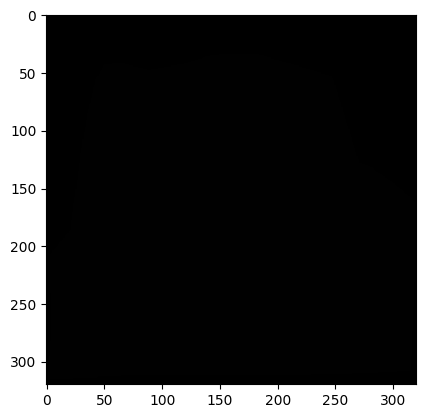

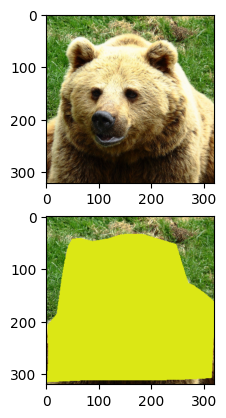

In [58]:
img,annotation=train[1]
img=img.permute(1,2,0)
fig, ax = plt.subplots(2)
ax[0].imshow(img)
im2=img.numpy().copy()
for i in range(len(annotation['masks'])):
    msk=annotation['masks'][i].numpy()
    im2[:,:,0][(msk>0.5)] = random.random()
    im2[:, :, 1][(msk>0.5)] = random.random()
    im2[:, :, 2][(msk>0.5)] = random.random()
    break
ax[1].imshow(im2)

plt.show()

In [44]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(coco_names)
model = get_object_detection_model(num_classes)
model.to(device);

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
epochs=1
for epoch in range(epochs):
    epoch_loss=0
    for images, targets in tqdm(data_loader):
        if(len(targets[0]['boxes'])==0):
            continue
        optimizer.zero_grad()
        images=list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict=model(images,targets)
        loss = sum(loss for loss in loss_dict.values())
        epoch_loss+=loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

In [ ]:
torch.save(model.state_dict(),'/kaggle/working/instance_model.pt')
model.load_state_dict(torch.load('/kaggle/working/instance_model.pt'))

In [ ]:
img,annotation=train[0]
pred=model(img)
img=img.permute(1,2,0)
fig, ax = plt.subplots(2)
ax[0].imshow(img)
im2=img.numpy().copy()
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    for pred,score in zip(prediction['masks'],prediction['scores']):
        if(score>0.65)
            msk=annotation['masks'][i].detach().cpu().numpy()
            im2[:,:,0][(msk>0.5)] = random.random()
            im2[:, :, 1][(msk>0.5)] = random.random()
            im2[:, :, 2][(msk>0.5)] = random.random()
ax[1].imshow(im2)

plt.show()